# Preprocessing + NN Playing for Beer Reviews

In [1]:
pip install liac-arff

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arff

## Load Dataset and create Dataframe

In [4]:
data = arff.load(open('../data/beer_reviews.arff', 'r'))
attr = np.array(data['attributes'])
numericals = [i[0] for i in attr if i[1] == 'INTEGER' or i[1] == 'REAL']
df = pd.DataFrame(data['data'], columns=attr[:, 0])
df.columns

Index(['brewery_id', 'brewery_name', 'review_time', 'review_overall',
       'review_aroma', 'review_appearance', 'review_profilename', 'beer_style',
       'review_palate', 'review_taste', 'beer_name', 'beer_abv',
       'beer_beerid'],
      dtype='object')

In [5]:
df.columns

df['review_time'] = df['review_time'].apply(lambda sec: pd.Timestamp(sec, unit='s'))
display(df.head())

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,2009-02-16 20:57:03,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,2009-03-01 13:44:57,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,2009-03-01 14:10:04,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,2009-02-15 19:12:25,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,2010-12-30 18:53:26,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


## Fix Missing Values

The rows with missing brewery name for id 1193 are found through a quick google search and added. For the ones with brewery id 27 where the beers already exist with the correct brewery, so I add it based on the dataset. For the others I google with the provided data.

The missing review profilenames are set to anonynoums, but otherwise kept, because the review is still done correctly.

In [6]:
display(df[df.isna().any(axis=1)])
display(df[df['brewery_name'].isna()])

display(df[df['brewery_id'] == 1193])
df.loc[df['brewery_id'] == 1193, 'brewery_name'] = 'Crailsheimer Engel-Bräu'
df.loc[df['brewery_id'] == 1193, 'beer_name'] = df.loc[df['brewery_id'] == 1193, 'beer_name'].apply(lambda name: name.split(' WRONG')[0])
display(df[df['brewery_id'] == 1193])

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
273,1075,Caldera Brewing Company,2004-12-21 22:29:55,3.0,3.0,3.0,RedDiamond,American Stout,4.0,3.0,Cauldron Espresso Stout,NaN,21241
430,850,Moon River Brewing Company,2005-03-13 17:48:30,3.5,4.0,4.5,cMonkey,Scotch Ale / Wee Heavy,3.5,3.5,The Highland Stagger,NaN,20689
603,850,Moon River Brewing Company,2004-11-09 22:20:19,4.0,3.5,4.0,aracauna,Scotch Ale / Wee Heavy,3.5,3.5,The Highland Stagger,NaN,20689
733,1075,Caldera Brewing Company,2009-12-13 03:12:01,4.0,4.0,4.0,plaid75,American IPA,4.0,4.0,Alpha Beta,NaN,54723
798,1075,Caldera Brewing Company,2008-05-31 02:34:28,4.5,4.5,4.0,grumpy,American Double / Imperial Stout,4.0,4.5,Imperial Stout,NaN,42964
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586568,14359,The Defiant Brewing Company,2007-08-14 00:49:27,4.0,3.5,4.0,maddogruss,Bock,4.0,4.0,Bock,NaN,36424
1586587,14359,The Defiant Brewing Company,2007-04-29 10:22:48,3.5,4.5,4.0,BBM,Maibock / Helles Bock,4.5,4.0,Maibock,NaN,36555
1586596,14359,The Defiant Brewing Company,2010-10-24 20:11:07,4.0,3.0,5.0,hoppymcgee,Belgian Strong Pale Ale,4.0,3.5,Resolution #2,NaN,48360
1586597,14359,The Defiant Brewing Company,2009-05-09 21:57:03,4.5,4.5,4.0,WesWes,Belgian Strong Pale Ale,4.0,4.0,Resolution #2,NaN,48360


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
651565,1193,None,2011-03-25 03:01:06,2.0,2.5,2.5,Knapp85,Vienna Lager,1.5,1.5,Engel Tyrolian Bräu WRONG BREWERY SEE SCHWABIS...,5.0,67503
659293,1193,None,2010-11-18 19:14:58,4.0,4.5,3.5,dqrull,Bock,4.0,3.5,Engel Bock Dunkel WRONG BREWERY SEE CRAILSHEIMER,7.2,63658
659299,1193,None,2010-11-06 20:56:41,3.5,3.0,3.0,dqrull,Dortmunder / Export Lager,4.0,4.0,Engel Gold WRONG BREWERY SEE CRAILSHEIMER,5.4,63215
659300,1193,None,2010-11-15 19:57:13,3.5,4.0,3.5,dqrull,Munich Helles Lager,3.5,3.0,Engel Landbier WRONG BREWERY SEE CRAILSHEIMER,4.8,63557
659301,1193,None,2010-11-07 19:37:12,3.5,4.0,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,3.5,Engel Keller Hell WRONG BREWERY SEE CRAILSHEIMER,5.4,63256
659302,1193,None,2010-11-12 19:27:45,3.5,4.0,3.0,dqrull,Vienna Lager,3.0,3.5,Engel Aloisius - WRONG BREWERY SEE CRAILSHEIMER,5.9,63459
659303,1193,None,2011-02-19 01:28:46,3.0,3.0,3.0,Ochsenblut,Keller Bier / Zwickel Bier,2.0,3.0,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324
659304,1193,None,2010-12-15 14:27:51,4.5,4.0,4.0,Dentist666,Keller Bier / Zwickel Bier,4.0,4.5,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324
659305,1193,None,2010-11-09 19:12:42,3.5,3.5,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,4.0,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324
1391043,27,None,2002-05-01 09:20:56,3.5,3.5,3.5,Jason,American Adjunct Lager,4.0,3.5,Hard Hat American Beer,3.8,60


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
651565,1193,None,2011-03-25 03:01:06,2.0,2.5,2.5,Knapp85,Vienna Lager,1.5,1.5,Engel Tyrolian Bräu WRONG BREWERY SEE SCHWABIS...,5.0,67503
659293,1193,None,2010-11-18 19:14:58,4.0,4.5,3.5,dqrull,Bock,4.0,3.5,Engel Bock Dunkel WRONG BREWERY SEE CRAILSHEIMER,7.2,63658
659299,1193,None,2010-11-06 20:56:41,3.5,3.0,3.0,dqrull,Dortmunder / Export Lager,4.0,4.0,Engel Gold WRONG BREWERY SEE CRAILSHEIMER,5.4,63215
659300,1193,None,2010-11-15 19:57:13,3.5,4.0,3.5,dqrull,Munich Helles Lager,3.5,3.0,Engel Landbier WRONG BREWERY SEE CRAILSHEIMER,4.8,63557
659301,1193,None,2010-11-07 19:37:12,3.5,4.0,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,3.5,Engel Keller Hell WRONG BREWERY SEE CRAILSHEIMER,5.4,63256
659302,1193,None,2010-11-12 19:27:45,3.5,4.0,3.0,dqrull,Vienna Lager,3.0,3.5,Engel Aloisius - WRONG BREWERY SEE CRAILSHEIMER,5.9,63459
659303,1193,None,2011-02-19 01:28:46,3.0,3.0,3.0,Ochsenblut,Keller Bier / Zwickel Bier,2.0,3.0,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324
659304,1193,None,2010-12-15 14:27:51,4.5,4.0,4.0,Dentist666,Keller Bier / Zwickel Bier,4.0,4.5,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324
659305,1193,None,2010-11-09 19:12:42,3.5,3.5,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,4.0,Engel Keller Dunkel WRONG BREWERY SEE CRAILSH...,5.3,63324


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
651565,1193,Crailsheimer Engel-Bräu,2011-03-25 03:01:06,2.0,2.5,2.5,Knapp85,Vienna Lager,1.5,1.5,Engel Tyrolian Bräu,5.0,67503
659293,1193,Crailsheimer Engel-Bräu,2010-11-18 19:14:58,4.0,4.5,3.5,dqrull,Bock,4.0,3.5,Engel Bock Dunkel,7.2,63658
659299,1193,Crailsheimer Engel-Bräu,2010-11-06 20:56:41,3.5,3.0,3.0,dqrull,Dortmunder / Export Lager,4.0,4.0,Engel Gold,5.4,63215
659300,1193,Crailsheimer Engel-Bräu,2010-11-15 19:57:13,3.5,4.0,3.5,dqrull,Munich Helles Lager,3.5,3.0,Engel Landbier,4.8,63557
659301,1193,Crailsheimer Engel-Bräu,2010-11-07 19:37:12,3.5,4.0,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,3.5,Engel Keller Hell,5.4,63256
659302,1193,Crailsheimer Engel-Bräu,2010-11-12 19:27:45,3.5,4.0,3.0,dqrull,Vienna Lager,3.0,3.5,Engel Aloisius -,5.9,63459
659303,1193,Crailsheimer Engel-Bräu,2011-02-19 01:28:46,3.0,3.0,3.0,Ochsenblut,Keller Bier / Zwickel Bier,2.0,3.0,Engel Keller Dunkel,5.3,63324
659304,1193,Crailsheimer Engel-Bräu,2010-12-15 14:27:51,4.5,4.0,4.0,Dentist666,Keller Bier / Zwickel Bier,4.0,4.5,Engel Keller Dunkel,5.3,63324
659305,1193,Crailsheimer Engel-Bräu,2010-11-09 19:12:42,3.5,3.5,4.0,dqrull,Keller Bier / Zwickel Bier,4.0,4.0,Engel Keller Dunkel,5.3,63324


In [7]:
display(df[df['brewery_id'] == 27])

df.loc[1391053, 'brewery_id'] = 24831
df.loc[1391053, 'brewery_name'] = 'American Brewing Company'

df.loc[1391051, 'brewery_id'] = 24831
df.loc[1391051, 'brewery_name'] = 'American Brewing Company'
df.loc[1391052, 'brewery_id'] = 24831
df.loc[1391052, 'brewery_name'] = 'American Brewing Company'

df.loc[1391049, 'brewery_id'] = 782
df.loc[1391049, 'brewery_name'] = 'City Brewing Company, LLC'
df.loc[1391049, 'beer_name'] = 'Side Pocket High Gravity Ale'
df.loc[1391050, 'brewery_id'] = 782
df.loc[1391050, 'brewery_name'] = 'City Brewing Company, LLC'
df.loc[1391050, 'beer_name'] = 'Side Pocket High Gravity Ale'

df.drop(1391043, inplace=True)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
1391043,27,None,2002-05-01 09:20:56,3.5,3.5,3.5,Jason,American Adjunct Lager,4.0,3.5,Hard Hat American Beer,3.8,60
1391049,27,None,2006-03-24 06:49:16,2.5,2.0,2.0,BeerBob,American Malt Liquor,2.0,2.0,Side Pocket,8.5,3394
1391050,27,None,2005-06-05 09:20:32,1.5,1.5,2.0,feloniousmonk,American Malt Liquor,1.5,1.5,Side Pocket,8.5,3394
1391051,27,None,2011-12-08 03:24:34,4.5,4.5,3.5,ccrida,American IPA,4.5,4.5,Breakaway IPA,7.2,75135
1391052,27,None,2011-11-11 05:36:14,3.5,4.0,3.5,Docer,American IPA,4.0,4.0,Breakaway IPA,7.2,75135
1391053,27,None,2011-11-11 07:10:08,5.0,4.5,4.0,Docer,American Stout,4.5,4.5,Caboose Oatmeal Stout,7.0,75137


In [8]:
df.loc[df['review_profilename'].isna(), 'review_profilename'] = 'Anonymous'

In [9]:
len(df['beer_style'].unique())

104

In [10]:
display(len(df.loc[df['beer_abv'].isna(), 'beer_name'].unique()))

def create_mean(df):
    means = {}
    for style in df['beer_style'].unique():
        mean_abv = df.loc[df['beer_style'] == style, 'beer_abv'].mean()
        means[style] = round(mean_abv, 1)

    return means

def fill_mean(means, row):
    return 

means = create_mean(df)
print(means)
df.loc[df['beer_abv'].isna(), 'beer_abv'] = df.loc[df['beer_abv'].isna()].apply(lambda row: means[row['beer_style']], axis=1)

14110

{'Hefeweizen': 5.3, 'English Strong Ale': 7.3, 'Foreign / Export Stout': 7.7, 'German Pilsener': 5.0, 'American Double / Imperial IPA': 9.4, 'Herbed / Spiced Beer': 6.6, 'Light Lager': 4.0, 'Oatmeal Stout': 5.8, 'American Pale Lager': 5.0, 'Rauchbier': 5.7, 'American Pale Ale (APA)': 5.5, 'American Porter': 6.2, 'Belgian Strong Dark Ale': 9.4, 'American IPA': 6.6, 'American Stout': 6.3, 'Russian Imperial Stout': 10.0, 'American Amber / Red Ale': 6.0, 'American Strong Ale': 9.8, 'Märzen / Oktoberfest': 5.9, 'American Adjunct Lager': 4.9, 'American Blonde Ale': 5.0, 'Euro Pale Lager': 5.1, 'English Brown Ale': 5.2, 'Scotch Ale / Wee Heavy': 8.2, 'Fruit / Vegetable Beer': 5.8, 'American Double / Imperial Stout': 10.6, 'Belgian Pale Ale': 6.1, 'English Bitter': 4.3, 'English Porter': 5.7, 'Irish Dry Stout': 4.9, 'American Barleywine': 10.7, 'Belgian Strong Pale Ale': 8.7, 'Doppelbock': 8.3, 'Maibock / Helles Bock': 6.8, 'Pumpkin Ale': 6.6, 'Dortmunder / Export Lager': 5.5, 'Euro Strong Lag

In [11]:
print(df[df.isna().any(axis=1)].count())

brewery_id            0
brewery_name          0
review_time           0
review_overall        0
review_aroma          0
review_appearance     0
review_profilename    0
beer_style            0
review_palate         0
review_taste          0
beer_name             0
beer_abv              0
beer_beerid           0
dtype: int64


## Splitting Training and Test Set

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [13]:
le = LabelEncoder()
le.fit(df['beer_style'])
df['class'] = le.transform(df['beer_style'])

In [14]:
le = LabelEncoder()
le.fit(df['review_profilename'])
df['review_profilecode'] = le.transform(df['review_profilename'])

In [15]:
X = df.copy()
X.drop('brewery_name', axis=1, inplace=True)
X.drop('beer_name', axis=1, inplace=True)
X.drop('beer_style', axis=1, inplace=True)
X.drop('review_profilename', axis=1, inplace=True)
X.drop('review_time', axis=1, inplace=True)

y = df['class']
X.drop('class', axis=1, inplace=True)
# X = normalize(X, norm='l2')
X

,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid,review_profilecode
0,10325,1.5,2.0,2.5,1.5,1.5,5.0,47986,30567
1,10325,3.0,2.5,3.0,3.0,3.0,6.2,48213,30567
2,10325,3.0,2.5,3.0,3.0,3.0,6.5,48215,30567
3,10325,3.0,3.0,3.5,2.5,3.0,5.0,47969,30567
4,1075,4.0,4.5,4.0,4.0,4.5,7.7,64883,23009
...,...,...,...,...,...,...,...,...,...
1586609,14359,5.0,4.0,3.5,4.0,4.0,5.2,33061,24776
1586610,14359,4.0,5.0,2.5,2.0,4.0,5.2,33061,33152
1586611,14359,4.5,3.5,3.0,3.5,4.0,5.2,33061,12504
1586612,14359,4.0,4.5,4.5,4.5,4.5,5.2,33061,18487


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
print(X_train)
print(y.max())

         brewery_id  review_overall  review_aroma  review_appearance  \
346231          754             4.0           4.0                4.0   
605885          174             2.5           2.0                3.0   
56385           688             4.0           3.5                3.5   
1556899         345             2.0           3.0                4.0   
1357582         220             4.0           4.0                4.5   
...             ...             ...           ...                ...   
259178          881             2.5           2.0                2.0   
1414415         139             3.5           3.0                4.0   
131932         5318             4.0           4.0                4.0   
671155          651             4.0           3.5                4.0   
121958          273             3.0           2.5                3.5   

         review_palate  review_taste  beer_abv  beer_beerid  \
346231             4.0           4.0       4.2         6302   
605885   

## Scaling, Feature Selection, Outlier

## Check for Outliers

array([[<Axes: title={'center': 'brewery_id'}>,
        <Axes: title={'center': 'review_overall'}>,
        <Axes: title={'center': 'review_aroma'}>],
       [<Axes: title={'center': 'review_appearance'}>,
        <Axes: title={'center': 'review_palate'}>,
        <Axes: title={'center': 'review_taste'}>],
       [<Axes: title={'center': 'beer_abv'}>,
        <Axes: title={'center': 'beer_beerid'}>,
        <Axes: title={'center': 'review_profilecode'}>]], dtype=object)

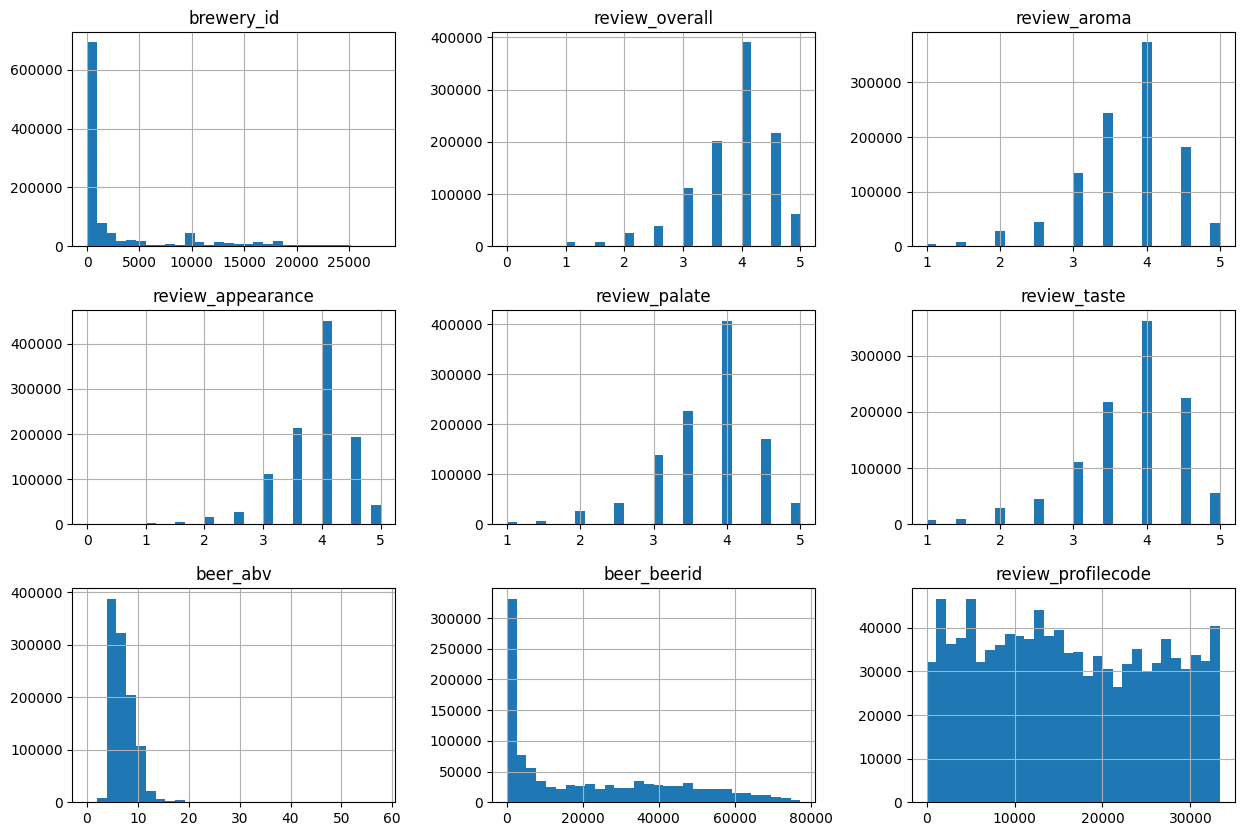

In [18]:
X_train.hist(bins=30, figsize=(15, 10))

In [19]:
len(X_train[X_train['beer_abv'] > 31])
len(X_train[X_train['beer_abv'] > 50])
X_train[X_train['beer_abv'] > 50]

,brewery_id,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid,review_profilecode
12919,6513,4.0,4.0,4.0,4.0,3.5,57.7,73368,23556


Looks like there exist really that strong beers.

## Feature Selection

In [20]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [32]:
clf = RandomForestClassifier(n_estimators=20, max_features=6).fit(X_train, y_train)
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train)
X_new.shape
X_new

KeyboardInterrupt: 

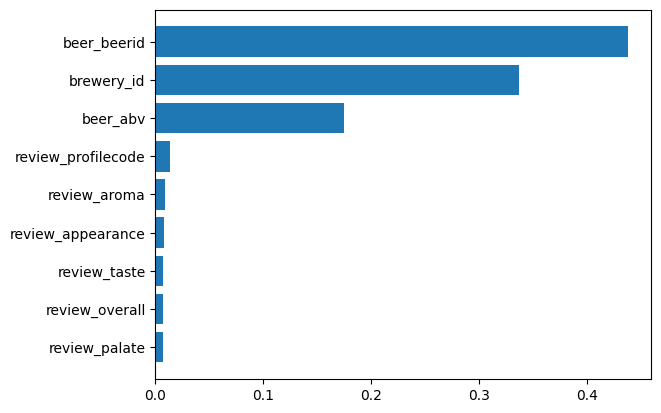

In [34]:
f_i = list(zip(clf.feature_names_in_,clf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [66]:
X_new = X_train[["review_overall", "beer_beerid", "brewery_id"]]

# Find Solution of NN + THEORIE!

In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [67]:
X_ttrain, X_valid, y_ttrain, y_valid = train_test_split(X_new, y_train.values, test_size=0.7, random_state=42)

In [42]:
print(X_ttrain)
print(y_ttrain)
print(y_ttrain.max())

[[3.1200e+03 8.0000e+00 7.5970e+03]
 [4.9490e+03 4.8000e+00 5.2429e+04]
 [4.1200e+02 1.1000e+01 1.2300e+03]
 ...
 [7.2000e+01 8.2000e+00 2.2400e+02]
 [2.2200e+02 8.5000e+00 6.9500e+02]
 [1.9200e+02 6.5000e+00 5.5081e+04]]
[  9 103  37 ... 100  26  12]
103


## Build torch dataset

In [37]:
assert not np.any(np.isnan(X_ttrain))
assert not np.any(np.isnan(y_ttrain))
assert not np.any(np.isnan(X_valid))
assert not np.any(np.isnan(y_valid))

In [58]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# convert a df to tensor to be used in pytorch
def X_to_tensor(df):
    return torch.from_numpy(df).float().to(device)

def y_to_tensor(df):
    return torch.from_numpy(df).long().to(device)

X_train_tensor = X_to_tensor(X_ttrain)
y_train_tensor = y_to_tensor(y_ttrain)

X_test_tensor = X_to_tensor(X_valid)
y_test_tensor = y_to_tensor(y_valid)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

Using cpu device


In [68]:
batch_size = 1024

# Create data loaders.
train_dataloader = DataLoader(train_ds, batch_size=batch_size)
test_dataloader = DataLoader(test_ds, batch_size=batch_size)

for XX, yy in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {XX.shape}")
    print(f"Shape of y: {yy.shape} {yy.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1024, 3])
Shape of y: torch.Size([1024]) torch.int64


## Creating Models

In [65]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 104)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=104, bias=True)
  )
)


## Train the Model

In [70]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [51]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (XX, yy) in enumerate(dataloader):
        XX, yy = XX.to(device), yy.to(device)

        # Compute prediction error
        pred = model(XX)
        loss = loss_fn(pred, yy)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(XX)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [52]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for XX, yy in dataloader:
            XX, yy = XX.to(device), yy.to(device)
            pred = model(XX)
            test_loss += loss_fn(pred, yy).item()
            correct += (pred.argmax(1) == yy).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [71]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1127.003906  [ 1024/318909]
loss: 4.634823  [103424/318909]
loss: 4.632919  [205824/318909]
loss: 4.630888  [308224/318909]
Test Error: 
 Accuracy: 4.0%, Avg loss: 4.630792 

Epoch 2
-------------------------------
loss: 4.632373  [ 1024/318909]
loss: 4.630936  [103424/318909]
loss: 4.629152  [205824/318909]
loss: 4.627107  [308224/318909]
Test Error: 
 Accuracy: 4.0%, Avg loss: 4.626825 

Epoch 3
-------------------------------
loss: 4.628375  [ 1024/318909]
loss: 4.627072  [103424/318909]
loss: 4.625410  [205824/318909]
loss: 4.623349  [308224/318909]
Test Error: 
 Accuracy: 4.0%, Avg loss: 4.622882 

Epoch 4
-------------------------------
loss: 4.624402  [ 1024/318909]
loss: 4.623234  [103424/318909]
loss: 4.621691  [205824/318909]
loss: 4.619616  [308224/318909]
Test Error: 
 Accuracy: 4.0%, Avg loss: 4.618965 

Epoch 5
-------------------------------
loss: 4.620454  [ 1024/318909]
loss: 4.619420  [103424/318909]
loss: 4.617997  [20582

KeyboardInterrupt: 